# 代码实现

接下来，我们编程实现Sobel算子与图像的卷积，首先先导入lena图像，并编写沿$X$轴方向和$Y$轴方向的Sobel算子。


(-0.5, 788.5, 430.5, -0.5)

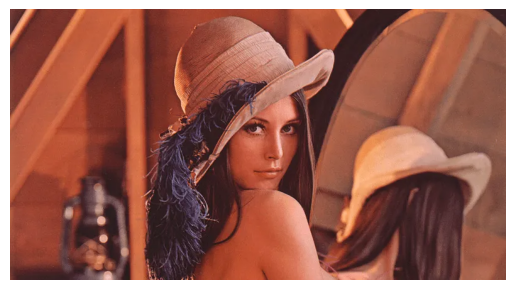

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# 输入图像
img = cv2.imread('lena.jpeg')

# X轴方向算子
kx = np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])

# Y轴方向Sobel算子
ky = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1,-2,-1]
])

# 展示输入图像
plt.imshow(img[:, :, ::-1])
plt.axis('off')

接着，先计算$X$轴方向的梯度。利用已经学习过的卷积的知识，可以很轻松的编写出相应的代码。

(-0.5, 788.5, 430.5, -0.5)

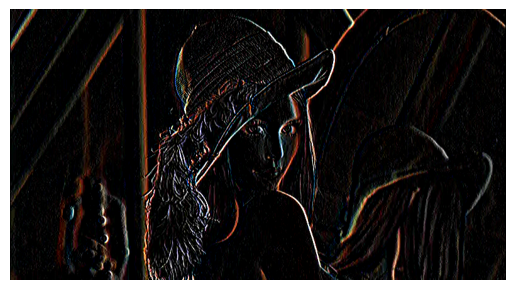

In [2]:
# X轴方向Sobel算子与图像进行卷积
conv_x = cv2.filter2D(img, -1, kx)
plt.imshow(conv_x[:, :, ::-1])
plt.axis('off')

可以观察到，沿$X$轴方向的梯度$\boldsymbol{I}_x$，也就是垂直方向上的边缘信息被有效检测出，如手臂的线条、帽子等。然后，再计算图像$Y$轴方向的梯度。

(-0.5, 788.5, 430.5, -0.5)

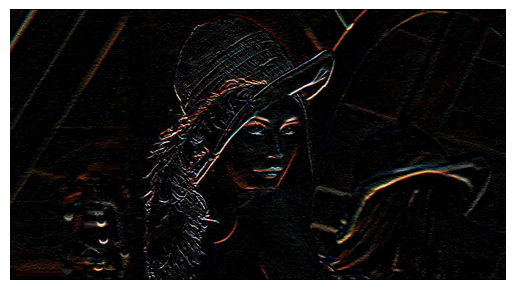

In [3]:
# Y轴方向Sobel算子与图像进行卷积
conv_y = cv2.filter2D(img, -1, ky)
plt.imshow(conv_y[:, :, ::-1])
plt.axis('off')

(-0.5, 788.5, 430.5, -0.5)

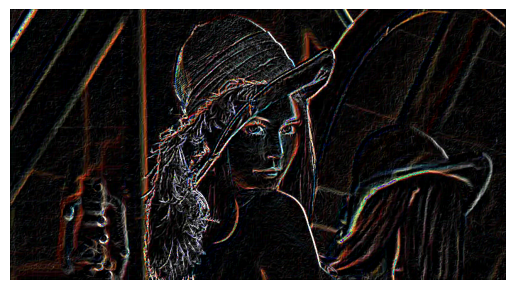

In [4]:
E = abs(conv_x) + abs(conv_y)
plt.imshow(E[:, :, ::-1])
plt.axis('off')

接下来进行Canny算子的编写。首先进行图像平滑。

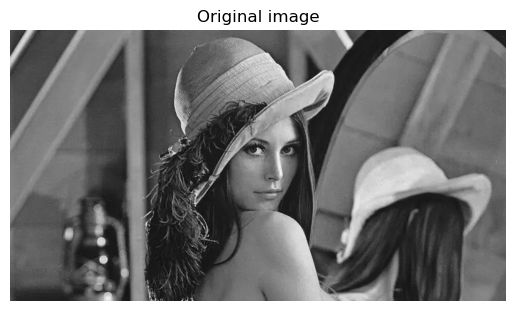

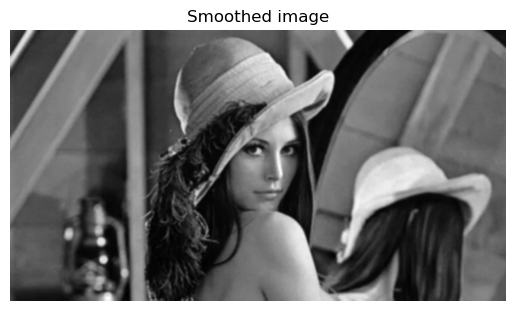

In [2]:
from utils import *
# 设定高斯核的大小与方差
kernel_size = 5
sigma = 1.5

# 导入一张图像
img = Image.open('lena.jpeg')

# 将其转为灰度图像
img = img.convert('L')
img = np.array(img)

# 构造高斯卷积核
kernel = gaussian_kernel(kernel_size, sigma)

# 与图像进行卷积
smoothed = cv2.filter2D(img, -1, kernel)

# 展示图像
plot_image(img, 'Original image')
plot_image(smoothed, 'Smoothed image')


对图像梯度进行计算。

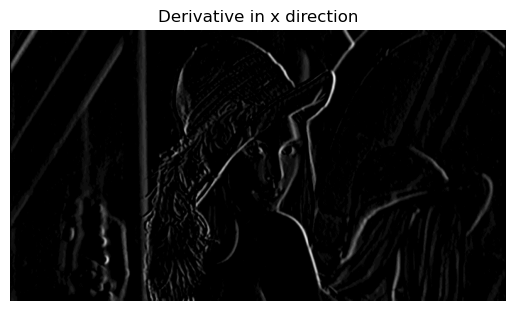

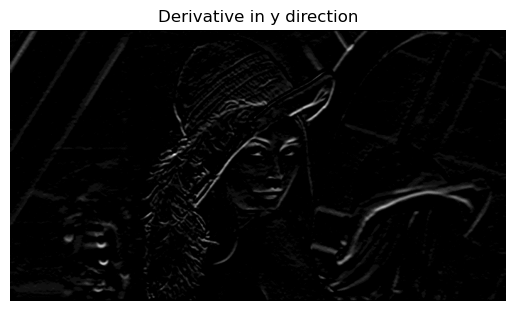

In [3]:
# 求X轴方向梯度
def partial_x(img):
    
    # 获得图像的大小
    Hi, Wi = img.shape  
    out = np.zeros((Hi, Wi))
    
    # 这里将卷积核均值化
    k = np.array([[0,0,0],[0.5,0,-0.5],[0,0,0]])
    
    # 对图像进行卷积
    out = cv2.filter2D(img, -1, k)
    
    return out


# 求Y轴方向梯度
def partial_y(img):
    Hi, Wi = img.shape  
    out = np.zeros((Hi, Wi))
    k = np.array([[0,0.5,0],[0,0,0],[0,-0.5,0]])
    out = cv2.filter2D(img, -1, k)
    return out


# 获得在两个方向上图像的梯度
Gx = partial_x(smoothed)
Gy = partial_y(smoothed)

# 绘制图像梯度
plot_image(Gx, 'Derivative in x direction')
plot_image(Gy, 'Derivative in y direction')

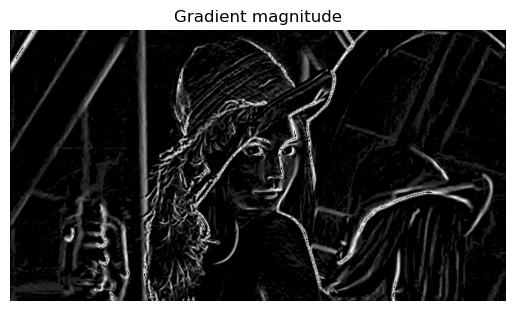

In [4]:
# 计算梯度以及方向
def gradient(img):
    G = np.zeros(img.shape)
    theta = np.zeros(img.shape)
    dx = partial_x(img)
    dy = partial_y(img)
    
    # 获得图像梯度
    G = np.sqrt(dx**2 + dy**2)
    
    # 获得梯度方向
    theta = np.rad2deg(np.arctan2(dy, dx))
    
    # 将梯度方向的大小调整为0-360之间
    theta %= 360

    return G, theta

G, theta = gradient(smoothed)

# 展示利用图像梯度得到的结果
plot_image(np.uint8(G), 'Gradient magnitude')

使用边缘强度非最大值抑制。

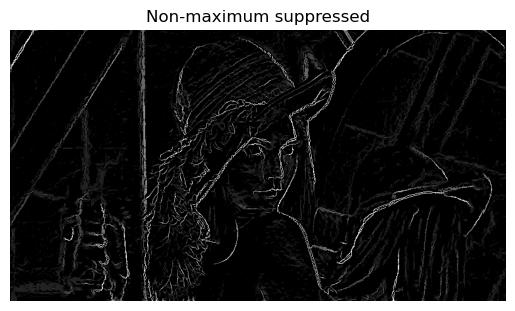

In [5]:
# 非最大值抑制算法
def non_maximum_suppression(G, theta):
    
    # 获得梯度图的大小
    H, W = G.shape

    # 将梯度方向投影到最近的45度角空间中
    theta = np.floor((theta + 22.5) / 45) * 45
    theta %= 360
    
    # 最后输出的图像梯度
    out = G.copy()
    
    for i in range(1, H-1):
        for j in range(1,W-1):
            
            # 当前像素点的角度大小，可以将其分为4类
            angle = theta[i,j]
            
            if angle == 0 or angle == 180:
                ma = max(G[i, j-1], G[i, j+1])
                
            elif angle == 45 or angle == 45 + 180:
                ma = max(G[i-1, j-1], G[i+1, j+1])
                
            elif angle == 90 or angle == 90 + 180:
                ma = max(G[i-1, j], G[i+1,j])
                
            elif angle == 135 or angle == 135 + 180:
                ma = max(G[i-1, j+1], G[i+1, j-1])
                
            else:
                print(angle)
                raise
            # ma是当前像素点相邻两个邻居点的像素梯度的最大值
            
            # 如果ma的值大于当前像素点的梯度值，则认为当前点非边缘
            # 并将该点的梯度值设置为0
            if ma > G[i,j]:
                out[i,j]=0
    return out


nms = non_maximum_suppression(G, theta)
plot_image(np.uint8(nms), 'Non-maximum suppressed')

编程实现通过双阈值确定强弱边缘。

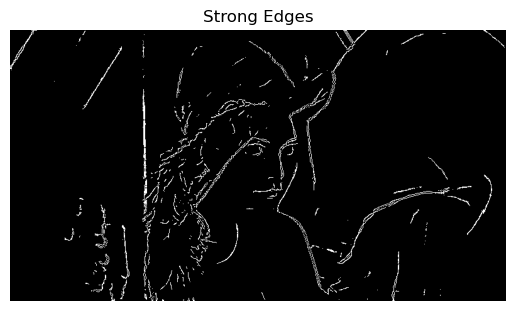

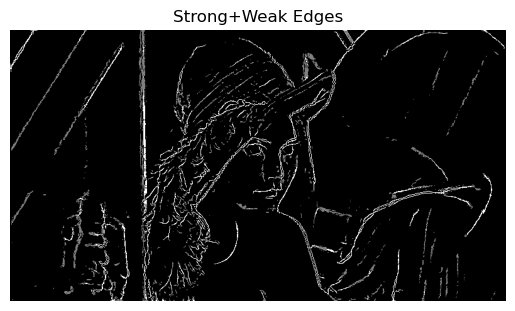

In [6]:
# 双阈值确定强弱边缘
def double_thresholding(img, high, low):
    # 初始化强弱边缘为布尔矩阵
    strong_edges = np.zeros(img.shape, dtype=np.bool_)
    weak_edges = np.zeros(img.shape, dtype=np.bool_)
    
    # 获得输入图像大小
    a,b = img.shape
    for i in range(a):
        for j in range(b):
            # 大于Th阈值则为强边缘
            if img[i,j] > high:
                strong_edges[i,j] = 1
                
            # 小于Th阈值大于Tl阈值则为弱边缘
            elif img[i,j] <= high and img[i,j] > low:
                weak_edges[i, j] = 1

    return strong_edges, weak_edges


low_threshold = 3
high_threshold = 6

strong_edges, weak_edges = double_thresholding(nms, 
                    high_threshold, low_threshold)

# 返回强弱边缘叠加的边缘图
edges = strong_edges * 1.0 + weak_edges * 0.5

plot_image(strong_edges, 'Strong Edges')
plot_image(edges, 'Strong+Weak Edges')

实现对弱边缘点的确定过程。

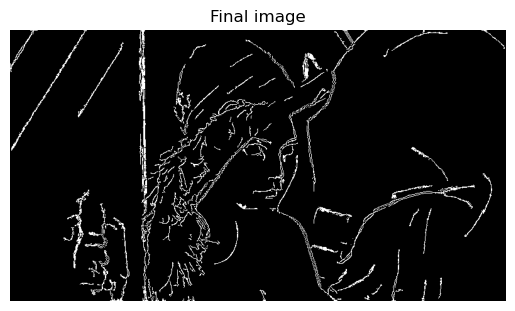

In [7]:
# 获得在(x，y)处点的邻居
def get_neighbors(x, y, H, W):
    neighbors = []
    for i in (x - 1, x, x + 1):
        for j in (y - 1, y, y + 1):
            if i >= 0 and i < H and j >= 0 and j < W:
                if (i == x and j == y):
                    continue
                neighbors.append((i, j))

    return neighbors


# 判断弱边缘点是否为边缘
def link_edges(strong_edges, weak_edges):
    # 获得图的大小
    H, W = strong_edges.shape
    
    # 获得强边缘点的位置
    indices = np.stack(np.nonzero(strong_edges)).T
    
    # 初始化最终的结果，为布尔矩阵
    edges = np.zeros((H, W), dtype=np.bool_)

    weak_edges = np.copy(weak_edges)
    edges = np.copy(strong_edges)
    
    # 将所有强边缘点的坐标组合成一个列表
    q = [(i,j) for i in range(H) for j in range(W) if strong_edges[i,j]]
    
    while q:
        
        # pop()函数返回列表中的末尾元素，并将其从列表中删除
        i, j = q.pop()
        
        # (a, b)是(i, j)的邻居
        for a, b in get_neighbors(i, j, H, W):
            
            # 如果当前点是弱边缘点且在强边缘点的邻域内，即可认为该点是边缘点
            if weak_edges[a][b]:
                # 为了避免对同一弱边缘点重复判断，便将其值设置为0
                weak_edges[a][b] = 0
                
                # 在边缘点中添加该弱边缘点
                edges[a][b] = 1
                
                # 由于该弱边缘点已经变成边缘点，因此需要将其加入q中
                # 通过将该点放进q中，在下一次迭代中可判断该点周围是否存在弱边缘点
                q.append((a,b))
                
    return edges


# 获得最终边缘图
edges = link_edges(strong_edges, weak_edges)
plot_image(edges, 'Final image')

综上，我们将Canny边缘检测器封装成如下函数：

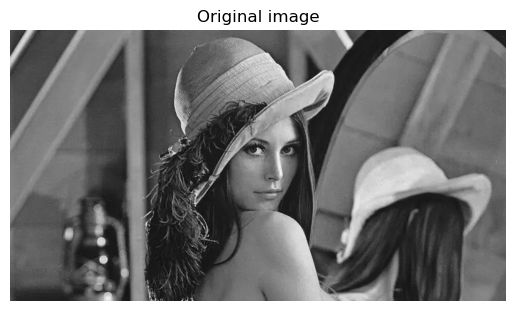

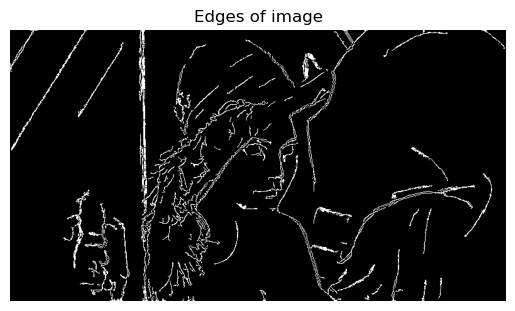

In [8]:
def canny(img, kernel_size=5, sigma=1.5, high=6, low=3):
    
    # 获取高斯滤波器
    kernel = gaussian_kernel(kernel_size, sigma)
    # 将图像进行高斯滤波
    smoothed = cv2.filter2D(img, -1, kernel)    
    # 得到图像的梯度图
    G, theta = gradient(smoothed)
    # 对梯度图进行nms
    nms = non_maximum_suppression(G, theta)
    # 获得强弱边缘信息
    strong_edges, weak_edges = double_thresholding(nms, high, low)
    # 对弱边缘进行分类，得到最终的边缘图
    edge = link_edges(strong_edges, weak_edges)

    return edge


plot_image(img, 'Original image')
canny_img = canny(img)
plot_image(canny_img, 'Edges of image')


调整高斯核的大小与标准差，观察比较不同的平滑程度对边缘检测结果的影响。

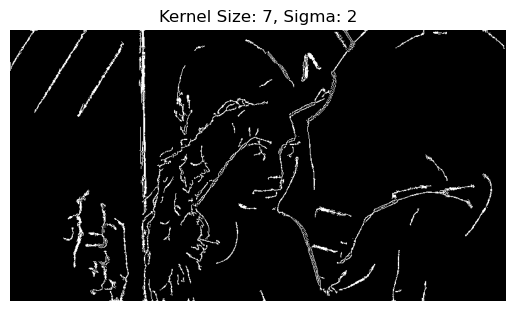

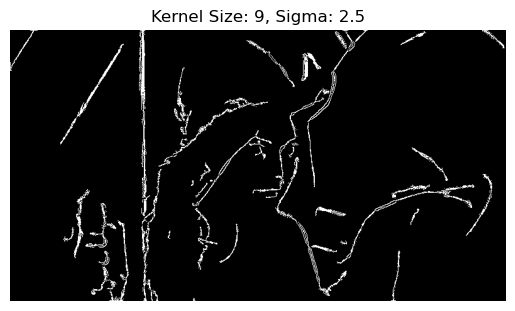

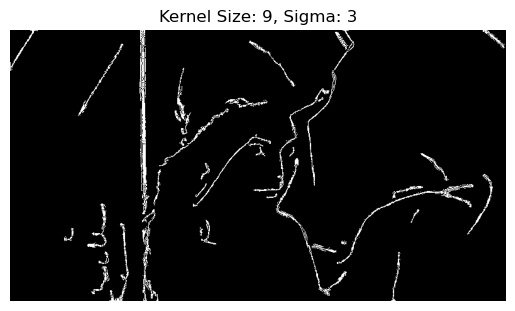

In [9]:
canny2 = canny(img, kernel_size=7, sigma=2)
plot_image(canny2, 'Kernel Size: 7, Sigma: 2')

canny2 = canny(img, kernel_size=9, sigma=2.5)
plot_image(canny2, 'Kernel Size: 9, Sigma: 2.5')

canny2 = canny(img, kernel_size=9, sigma=3)
plot_image(canny2, 'Kernel Size: 9, Sigma: 3')